In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-ilsum/train.csv
/kaggle/input/data-ilsum/test.csv


In [2]:
!pip install transformers sentencepiece datasets rouge -qq

In [3]:
import torch
import pandas as pd
from rouge import Rouge
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import plotly.express as px
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, ' ', data)

def preprocess_tokenize(text):
      # for removing punctuation from sentencesc
    text = str(text)
    text = re.sub(r'(\d+)', r'', text)
    
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\u200d', '')
    text=re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text=re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text=re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text=re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text=re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively
    text=re.sub(r"[<>()|&©@#ø\[\]\'\",;:?.~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!
    text = re.sub(r"[‘’।:]", " ", str(text)) #removing other special characters
    text = re.sub("([a-zA-Z])",' ',str(text)).lower()
    text = re.sub("(\s+)",' ',str(text)).lower()
    text = remove_emojis(text)
    return text

In [5]:
df = pd.read_csv('/kaggle/input/data-ilsum/test.csv')
df

,id,Article,Heading,Summary
0,e0da5a2de223a86eb552a07659dd47e2,नई दिल्ली. भारतीय जनता पार्टी ने अगले साल होने...,चुनाव वाले राज्यों के लिए BJP ने नियुक्त किए प...,उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ...
1,d02069b8347e435c9b7c31e7cd8b90c7,नयी दिल्ली। मिजोरम के साथ लगी सीमा पर शांति बह...,"असम-मिजोरम सीमा पर शांति बहाल, लेकिन एक दिन मे...",मिजोरम के साथ लगी सीमा पर शांति बहाल होने का उ...
2,bdfc6506a6e17c826c69188af1cf4473,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...,अरुणाचल से किशोर के अपहरण का मामला: सांसद गाओ...,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...
3,18fae0a6aaad48365e7422c65ba888d9,नई दिल्ली: दिल्ली पुलिस कमिश्नर एसएन श्रीवास्त...,किसान ट्रैक्टर रैली से पहले दिल्ली पुलिस कमिश्...,दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव (SN Shriv...
4,f2d34161dac5a41530be06a229702f7f,श्रीनगर: गृह मंत्री अमित शाह के जम्मू-कश्मीर द...,Amit Shah in J&K LIVE: कश्मीर का सीएम ऐसा हो ज...,जम्मू-कश्मीर दौरे के तीसरे दिन अमित शाह आज श्र...
...,...,...,...,...
2837,d49b0b111e6731baf7d4d5c06008a885,नई दिल्ली: कृषि मंत्री नरेंद्र सिंह तोमर ने एम...,"MSP पर प्रधानमंत्री ने कमेटी बनाई, पराली जलाना...","कृषि मंत्री ने कहा, तीनों कृषि कानूनों को वापस..."
2838,da3672fa0882bc9da61ef02a8ff7675e,लखनऊ: उत्तर प्रदेश की योगी आदित्यनाथ सरकार ने ...,"योगी सरकार ने 9 गेस्ट हाउस का नाम नदियों, धार्...",मुंबई में स्टेट गेस्ट हाउस अब यूपी स्टेट गेस्ट...
2839,3ba69cb51ad7600da7684ca8c051600b,नई दिल्ली। कोरोना वायरस को लेकर कुछ राहत की बा...,"Coronavirus से कुछ राहत, 7 लाख के नीचे आए एक्ट...",केंद्रीय स्वास्थ्य मंत्रालय की तरफ से शुक्रवार...
2840,039fdcf04c2bbcd1970e8c3fc60944a1,नई दिल्ली: केंद्रीय शहरी विकास मंत्री हरदीप सि...,"वाराणसी गंगा नदी के किनारे सबसे साफ शहर बना, प...",लोकसभा में इस शहर का प्रतिनिधित्व करने वाले प्...


In [6]:
df.drop(['id','Heading'], axis =1 , inplace = True)
df

,Article,Summary
0,नई दिल्ली. भारतीय जनता पार्टी ने अगले साल होने...,उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ...
1,नयी दिल्ली। मिजोरम के साथ लगी सीमा पर शांति बह...,मिजोरम के साथ लगी सीमा पर शांति बहाल होने का उ...
2,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...
3,नई दिल्ली: दिल्ली पुलिस कमिश्नर एसएन श्रीवास्त...,दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव (SN Shriv...
4,श्रीनगर: गृह मंत्री अमित शाह के जम्मू-कश्मीर द...,जम्मू-कश्मीर दौरे के तीसरे दिन अमित शाह आज श्र...
...,...,...
2837,नई दिल्ली: कृषि मंत्री नरेंद्र सिंह तोमर ने एम...,"कृषि मंत्री ने कहा, तीनों कृषि कानूनों को वापस..."
2838,लखनऊ: उत्तर प्रदेश की योगी आदित्यनाथ सरकार ने ...,मुंबई में स्टेट गेस्ट हाउस अब यूपी स्टेट गेस्ट...
2839,नई दिल्ली। कोरोना वायरस को लेकर कुछ राहत की बा...,केंद्रीय स्वास्थ्य मंत्रालय की तरफ से शुक्रवार...
2840,नई दिल्ली: केंद्रीय शहरी विकास मंत्री हरदीप सि...,लोकसभा में इस शहर का प्रतिनिधित्व करने वाले प्...


In [7]:
train_data_src = df['Article']
train_data_trg = df['Summary']

tokenized_corpus_src = [preprocess_tokenize(x) for x in train_data_src]
tokenized_corpus_trg = [preprocess_tokenize(x) for x in train_data_trg] 

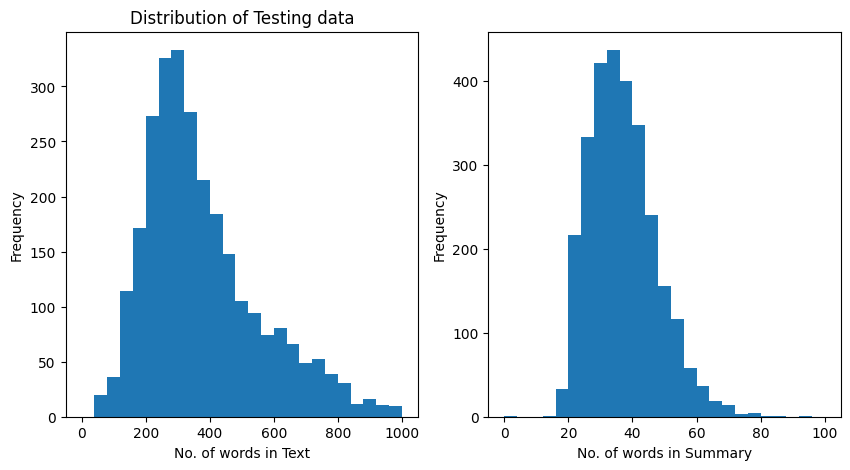

In [8]:
text_word_count =[]
summary_word_count =[]

for i in tokenized_corpus_src:
      text_word_count.append(len(i.split()))

for i in tokenized_corpus_trg:
      summary_word_count.append(len(i.split()))

fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].hist(text_word_count, bins=25, range=[0, 1000])
ax[1].hist(summary_word_count, bins=25, range=[0, 100])
ax[0].set_xlabel("No. of words in Text")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("No. of words in Summary")
ax[1].set_ylabel("Frequency")
ax[0].set_title('Distribution of Testing data')
plt.show()

In [9]:
df['Text_Cleaned'] = tokenized_corpus_src
print("::::: Text_Cleaned :::::")
print(df['Text_Cleaned'][0:5], "\n")


df['Summary_Cleaned'] =  tokenized_corpus_trg
print("::::: Summary :::::")
print(df['Summary_Cleaned'][0:5], "\n")

corpus = list(df['Text_Cleaned'])

::::: Text_Cleaned :::::
0    नई दिल्ली भारतीय जनता पार्टी ने अगले साल होने ...
1    नयी दिल्ली मिजोरम के साथ लगी सीमा पर शांति बहा...
2    अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...
3    नई दिल्ली दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव...
4    श्रीनगर गृह मंत्री अमित शाह के जम्मू-कश्मीर दौ...
Name: Text_Cleaned, dtype: object 

::::: Summary :::::
0    उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ...
1    मिजोरम के साथ लगी सीमा पर शांति बहाल होने का उ...
2    अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...
3    दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव ने गणतंत्...
4    जम्मू-कश्मीर दौरे के तीसरे दिन अमित शाह आज श्र...
Name: Summary_Cleaned, dtype: object 



In [10]:
max_text_len = 512
max_summary_len = 75

In [11]:
df.drop(['Article','Summary'], axis = 1, inplace = True)
df.columns =['Article', 'Summary']
df

,Article,Summary
0,नई दिल्ली भारतीय जनता पार्टी ने अगले साल होने ...,उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ...
1,नयी दिल्ली मिजोरम के साथ लगी सीमा पर शांति बहा...,मिजोरम के साथ लगी सीमा पर शांति बहाल होने का उ...
2,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...
3,नई दिल्ली दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव...,दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव ने गणतंत्...
4,श्रीनगर गृह मंत्री अमित शाह के जम्मू-कश्मीर दौ...,जम्मू-कश्मीर दौरे के तीसरे दिन अमित शाह आज श्र...
...,...,...
2837,नई दिल्ली कृषि मंत्री नरेंद्र सिंह तोमर ने एमए...,कृषि मंत्री ने कहा तीनों कृषि कानूनों को वापस ...
2838,लखनऊ उत्तर प्रदेश की योगी आदित्यनाथ सरकार ने अ...,मुंबई में स्टेट गेस्ट हाउस अब यूपी स्टेट गेस्ट...
2839,नई दिल्ली कोरोना वायरस को लेकर कुछ राहत की बात...,केंद्रीय स्वास्थ्य मंत्रालय की तरफ से शुक्रवार...
2840,नई दिल्ली केंद्रीय शहरी विकास मंत्री हरदीप सिं...,लोकसभा में इस शहर का प्रतिनिधित्व करने वाले प्...


In [12]:
data = df.iloc[:2001]

In [13]:
data

,Article,Summary
0,नई दिल्ली भारतीय जनता पार्टी ने अगले साल होने ...,उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ...
1,नयी दिल्ली मिजोरम के साथ लगी सीमा पर शांति बहा...,मिजोरम के साथ लगी सीमा पर शांति बहाल होने का उ...
2,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...
3,नई दिल्ली दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव...,दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव ने गणतंत्...
4,श्रीनगर गृह मंत्री अमित शाह के जम्मू-कश्मीर दौ...,जम्मू-कश्मीर दौरे के तीसरे दिन अमित शाह आज श्र...
...,...,...
1996,देश अभी भी कोरोना के संकट से जूझ रहा है इस बीच...,देश अभी भी कोरोना के संकट से जूझ रहा है इस बी...
1997,नई दिल्ली स्कूल में एडमिशन के लिए अब बच्चों का...,स्कूल में एडमिशन के लिए अब बच्चों का आधार कार्...
1998,लखनऊ राजधानी के अवध शिल्पग्राम में बिस्तरों से...,राजधानी के अवध शिल्पग्राम में बिस्तरों से अधिक...
1999,नई दिल्ली सोशल मीडिया पर एक पोस्ट और उसके साथ ...,वायरल पोस्ट और वीडियो में दावा किया जा रहा है ...


In [14]:
text = data['Article']
goldsummary = data['Summary']

In [15]:
bart_checkpoint = "ai4bharat/IndicBART"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
tokenizer_bart = AutoTokenizer.from_pretrained(bart_checkpoint, 
                                               do_lower_case=False, 
                                               use_fast=False, 
                                               keep_accents=True)

model_bart = AutoModelForSeq2SeqLM.from_pretrained(bart_checkpoint).to(device)

bos_id = tokenizer_bart._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer_bart._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer_bart._convert_token_to_id_with_added_voc("<pad>")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



In [17]:
%%time

SystemSummary = []

for i, input_text in enumerate(text):
    print(i,end = ",")
    inp = tokenizer_bart(input_text, add_special_tokens=False, 
                         truncation=True, return_tensors="pt", 
                         padding='max_length', max_length=512)['input_ids'].to(device)
    
    model_output = model_bart.generate(inp, use_cache=True, 
                                        num_beams=4, 
                                        max_length=75, 
                                        min_length=75, 
                                        early_stopping=True, 
                                        pad_token_id=pad_id,
                                        bos_token_id=bos_id, 
                                        eos_token_id=eos_id, 
                                        decoder_start_token_id=tokenizer_bart._convert_token_to_id_with_added_voc("<2en>"))
    
    decoded_output = tokenizer_bart.decode(model_output[0], 
                                    skip_special_tokens=True, 
                                    clean_up_tokenization_spaces=False)
    
    SystemSummary.append(decoded_output)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,42

In [18]:
Summaries = pd.DataFrame(list(zip(goldsummary, SystemSummary)), columns =['Human Summary', 'Generated Summary'])
Summaries

,Human Summary,Generated Summary
0,उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ...,नई दिल्ली भारतीय जनता पार्टी ने अगले साल होने ...
1,मिजोरम के साथ लगी सीमा पर शांति बहाल होने का उ...,नयी दिल्ली मिजोरम के साथ लगी सीमा पर शांति बहा...
2,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...,अरुणाचल प्रदेश के भाजपा सांसद तापिर गाओ ने कहा...
3,दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव ने गणतंत्...,नई दिल्ली दिल्ली पुलिस कमिश्नर एसएन श्रीवास्तव...
4,जम्मू-कश्मीर दौरे के तीसरे दिन अमित शाह आज श्र...,श्रीनगर गृह मंत्री अमित शाह के जम्मू-कश्मीर दौ...
...,...,...
1996,देश अभी भी कोरोना के संकट से जूझ रहा है इस बी...,देश अभी भी कोरोना के संकट से जूझ रहा है इस बीच...
1997,स्कूल में एडमिशन के लिए अब बच्चों का आधार कार्...,नई दिल्ली स्कूल में एडमिशन के लिए अब बच्चों का...
1998,राजधानी के अवध शिल्पग्राम में बिस्तरों से अधिक...,लखनऊ राजधानी के अवध शिल्पग्राम में बिस्तरों से...
1999,वायरल पोस्ट और वीडियो में दावा किया जा रहा है ...,नई दिल्ली सोशल मीडिया पर एक पोस्ट और उसके साथ ...


In [19]:
Summaries.to_csv('results.csv')

In [22]:
!pip install -q evaluate

In [24]:
!pip install -q rouge_score

In [28]:
Summaries['Human Summary'][0]

'उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ठाकुर अर्जुन मेघवाल सरोज पांडेय शोभा करंदलाजे कैप्टन अभिमन्यु अन्नपूर्णा देवी विवेक ठाकुर को सह प्रभारी की जिम्मेदारी दी है '

In [29]:
Summaries['Generated Summary'][0]

'नई दिल्ली भारतीय जनता पार्टी ने अगले साल होने वाले चुनावों के चुनाव प्रभारियों की नियुक्तियां की हैं भाजपा के लिहाज से सबसे महत्वपूर्ण राज्य उत्तर प्रदेश का जिम्मा धर्मेंद्र प्रधान को दिया है धर्मेंद्र प्रधान यूपी के चुनाव प्रभारी होंगे गजेंद्र सिंह शेखावत को पंजाब का प्रभारी बनाया है उत्तर प्रदेश में भाजपा ने चुनाव के लिए अनुराग ठाकुर अर्जुन मेघवाल सरोज पांडेय शोभा करंद'

In [26]:
rouge = Rouge()
score = rouge.get_scores(Summaries['Generated Summary'], Summaries['Human Summary'], avg=True)
BartRouge = pd.DataFrame(score).set_index([['recall','precision','f-measure']])
BartRouge

,rouge-1,rouge-2,rouge-l
recall,0.731839,0.615283,0.676207
precision,0.461918,0.341835,0.424951
f-measure,0.557260,0.431509,0.513637


In [31]:
rouge = evaluate.load('rouge')
predictions = [i for i in Summaries['Generated Summary']]
references = [ i for i in Summaries['Human Summary']]
results = rouge.compute(predictions=predictions,references=references)
print(results)

{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
